In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import re
import nltk
import os
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV
from wordcloud import WordCloud
from myFunction import *

plt.style.use('ggplot')

# Preprocessing

In [2]:
user_df = pd.read_csv("./user_df_filtered_nplus.csv")

In [3]:
# clean review and stem
user_df["Clean_Review"] = user_df["Review"].apply(clean_text)
user_df["Clean_Review"] = user_df["Clean_Review"].apply(stem_text)
user_df.head(100)

,Unnamed: 0,Game Name,Review,Rating,Clean_Review
0,0,Wolfenstein: The Old Blood,Decided to play some culturally and historical...,70,decid to play some cultur and histor relev med...
1,1,Wolfenstein: The Old Blood,if you are very hungry for more neo-wolfenstei...,70,if you are veri hungri for more neowolfenstein...
2,2,Wolfenstein: The Old Blood,Slightly less fun version of the New Order,60,slightli less fun version of the new order
3,3,Wolfenstein: The Old Blood,Part 1 is a tad of a slog by comparison with p...,70,part is a tad of a slog by comparison with par...
4,4,Wolfenstein: The Old Blood,This was a relatively short game. I beat the g...,60,thi wa a rel short game i beat the game on ube...
...,...,...,...,...,...
95,95,Wolfenstein: The Old Blood,why is it like 4 hours long,60,whi is it like hour long
96,96,Wolfenstein: The Old Blood,Playtime: 5:30 HoursAt first this standalone D...,70,playtim hoursat first thi standalon dlc wa too...
97,97,Wolfenstein: The Old Blood,Most of what can be said about Wolfenstein: Th...,70,most of what can be said about wolfenstein the...
98,98,Wolfenstein: The Old Blood,A good prequel toWolfenstein: The New Ordertha...,80,a good prequel towolfenstein the new orderthat...


In [4]:
X_temp, _, y_train, y_test = train_test_split(user_df[["Clean_Review"]],
                                              user_df["Rating"],
                                              test_size=0.2,
                                              random_state=42)
scaler_y = MinMaxScaler()
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))

## TF-IDF

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, 
                                   ngram_range=(1, 3), 
                                   stop_words='english', 
                                   min_df=5, 
                                   max_df=0.95)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_temp["Clean_Review"])
X_tfidf_test = tfidf_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])

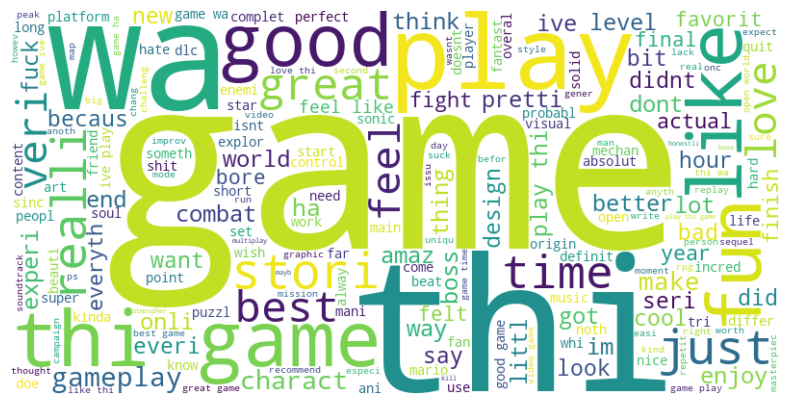

In [6]:
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_means = X_tfidf_train.mean(axis=0).A1
tfidf_dict = dict(zip(feature_names, tfidf_means))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## N-gram

In [7]:
ngram_vectorizer = CountVectorizer(max_features=5000, 
                                   ngram_range=(1, 3), 
                                   stop_words='english', 
                                   min_df=5, 
                                   max_df=0.95)
X_ngrams_train = ngram_vectorizer.fit_transform(X_temp["Clean_Review"])
X_ngrams_test = ngram_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])

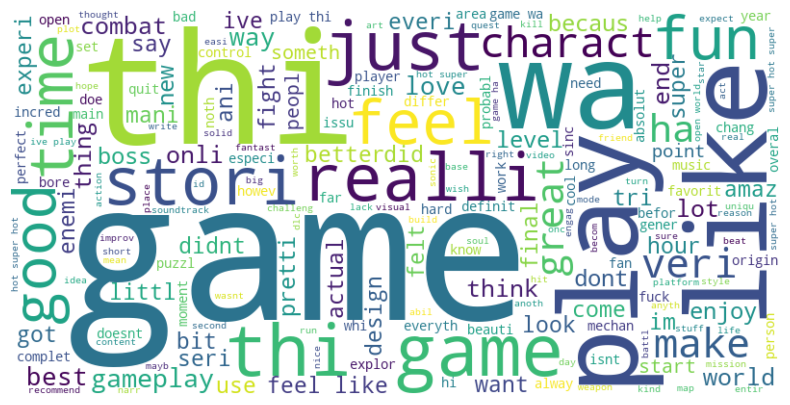

In [8]:
feature_names_ngrams = ngram_vectorizer.get_feature_names_out()

ngrams_means = X_ngrams_train.mean(axis=0).A1
ngrams_dict = dict(zip(feature_names_ngrams, ngrams_means))

wordcloud_ngrams = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(ngrams_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ngrams, interpolation="bilinear")
plt.axis("off")
plt.show()

## Embedding

In [9]:
tokenized_reviews = tokenize_reviews(user_df["Clean_Review"].tolist())

model = Word2Vec(sentences=tokenized_reviews, 
                 vector_size=100,
                 window=5, 
                 min_count=5,
                 workers=4)

batch_size = 10000
embeddings_train = []
for i in range(0, len(X_temp), batch_size):
    batch_reviews = X_temp["Clean_Review"].iloc[i:i + batch_size].tolist()
    batch_embeddings = [get_sentence_embedding(review, model) for review in batch_reviews]
    embeddings_train.extend(batch_embeddings)
X_embedding_train = np.array(embeddings_train, dtype=np.float32)

embeddings_test = []
for i in range(0, len(y_test), batch_size):
    batch_reviews = user_df.loc[y_test.index, "Clean_Review"].iloc[i:i + batch_size].tolist()
    batch_embeddings = [get_sentence_embedding(review, model) for review in batch_reviews]
    embeddings_test.extend(batch_embeddings)
X_embedding_test = np.array(embeddings_test, dtype=np.float32)


In [10]:
X_embedding_train_sparse = scipy.sparse.csr_matrix(X_embedding_train)
X_embedding_test_sparse = scipy.sparse.csr_matrix(X_embedding_test)

In [11]:
X_train_combined = scipy.sparse.hstack([X_tfidf_train, X_ngrams_train, X_embedding_train_sparse])
X_test_combined = scipy.sparse.hstack([X_tfidf_test, X_ngrams_test, X_embedding_test_sparse])

scaler_x = StandardScaler(with_mean=False)
X_train_scaled = scaler_x.fit_transform(X_train_combined)
X_test_scaled = scaler_x.transform(X_test_combined)

In [12]:
#nomrlise the data
scaler_x = StandardScaler(with_mean=False)
X_train_scaled = scaler_x.fit_transform(X_train_combined)
X_test_scaled = scaler_x.transform(X_test_combined)

In [ ]:
filename = 'scaler_x.plk'
pickle.dump(scaler_x, open(filename, 'wb'))

# Model Training

Benchmark model

In [14]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_scaled, y_train_normalized.flatten())
y_pred_dummy = dummy.predict(X_test_scaled)
mse_dummy = mean_squared_error(y_test_normalized, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
print(f"Dummy Regressor (Mean) - MSE: {mse_dummy:.4f}, RMSE: {rmse_dummy:.4f}")
#Dummy Regressor (Mean) - MSE: 0.0509, RMSE: 0.2255

Dummy Regressor (Mean) - MSE: 0.0509, RMSE: 0.2255


Lasso model


In [ ]:
lasso = LassoCV(alphas=np.logspace(-3, 1, 10), cv=5)  # fine-tuning
lasso.fit(X_train_scaled, y_train_normalized.flatten())

filename = 'lasso_model_user.sav'
pickle.dump(lasso, open(filename, 'wb'))

In [ ]:
print(f"Optimal alpha: {lasso.alpha_}")

Optimal alpha: 0.001


In [ ]:
#   Predict
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train_normalized.flatten())

y_pred = lasso.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test_normalized, y_pred)
print(f"Mean Squared Error: {mse_lasso:.4f}")

rmse_lasso = np.sqrt(mse_lasso)
print(f"Root Mean Squared Error: {rmse_lasso:.4f}")

feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
feature_names_ngrams = ngram_vectorizer.get_feature_names_out()

# important features
important_features_users = []
for idx, coef in enumerate(lasso.coef_):
    if abs(coef) > 0:
        if idx < len(feature_names_tfidf):
            important_features_users.append((feature_names_tfidf[idx], coef))
        elif idx < len(feature_names_tfidf)  + len(feature_names_ngrams):
            important_features_users.append((feature_names_ngrams[idx - len(feature_names_tfidf)], coef))
        else:
            important_features_users.append((f"Embedding_{idx - len(feature_names_tfidf)  - len(feature_names_ngrams)}", coef))

print("Some important model:")
print(important_features_users[:10])
#Mean Squared Error: 0.0323 Root Mean Squared Error: 0.1798
filename = 'lasso_model_user.sav'
pickle.dump(lasso, open(filename, 'wb'))

Mean Squared Error: 0.0325
Root Mean Squared Error: 0.1804
Some important model:
[('abandon', -0.0010381506633036699), ('abov', 0.0004004778807667136), ('absolut', 0.001267876147386671), ('absolut incred', 0.00033538900201941394), ('absolut love', 0.00010995473448214796), ('abus', -9.196894054748337e-05), ('abysm', -0.0034188878230791593), ('ac', -0.0001588405325638458), ('ac game', -0.00023241647181193709), ('access', 2.3857603482629502e-05)]


In [41]:
#print top 10 feature
important_features_users.sort(key=lambda x: abs(x[1]), reverse=True)
# print "overwatch" in important features
print(important_features_users[:10])

[('worst', -0.015439704476096747), ('bore', -0.013757965519680141), ('perfect', 0.011144813366835014), ('Embedding_46', 0.010062999064462905), ('Embedding_35', 0.010002178335617574), ('best', 0.009370888149131193), ('Embedding_69', 0.009321026523380058), ('wors', -0.009202924046085581), ('peak', 0.008859894395484388), ('disappoint', -0.008747266361985381)]


In [42]:
game_names = ["worst", "perfect", "blizzard", "overwatch", "halo"]

for game_name in game_names:
    result = next((item for item in important_features_users if item[0] == game_name), None)

    if result:
        print(f"\"{game_name}\" found with value: {result[1]}\n")
    else:
        print(f"\"{game_name}\" not found in the list.\n")

"worst" found with value: -0.015439704476096747

"perfect" found with value: 0.011144813366835014

"blizzard" found with value: -0.006134670311797987

"overwatch" found with value: -0.007158982140802573

"halo" found with value: -0.0031993205554845324



In [18]:
# un normalized prediction
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
print(f"Predicted User Scores (0-100):")
print(y_pred_original.flatten()[:10])

y_test_original = scaler_y.inverse_transform(y_test_normalized)
print(f"Actual User Scores (0-100):")
print(y_test_original.flatten()[:10])

# kendall accuracy
acc_users_lasso = kendall_acc(y_pred_original, y_test_original)
print("Users lasso kendall accuracy")
print(acc_users_lasso)

Predicted User Scores (0-100):
[73.84480063 85.17432184 76.62077875 74.8692743  98.65174821 84.02229662
 88.67539184 78.73392659 58.41992322 99.99996028]
Actual User Scores (0-100):
[ 80. 100.  90.  30. 100.  80.  70.  70.  10. 100.]
Users lasso kendall accuracy
     acc  lower  upper
0  73.61  73.23   74.0


ridge model

In [19]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train_scaled, y_train_normalized.flatten())
y_pred_ridge = ridge.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test_normalized, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f"Ridge Regression - MSE: {mse_ridge:.4f}, RMSE: {rmse_ridge:.4f}")

ridge_filename = 'ridge_model_user.sav'
pickle.dump(ridge, open(ridge_filename, 'wb'))

acc_users_ridge = kendall_acc(y_pred_ridge, y_test_normalized)
print("Users ridge kendall accuracy")
print(acc_users_ridge)

Ridge Regression - MSE: 0.0325, RMSE: 0.1803
Users ridge kendall accuracy
     acc  lower  upper
0  73.42  73.04  73.81


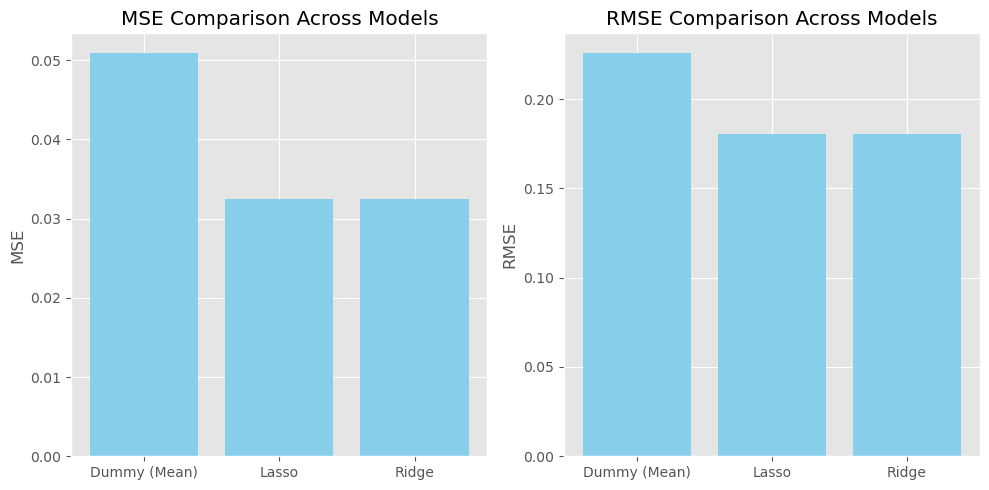

In [20]:
models = ['Dummy (Mean)', 'Lasso', 'Ridge']
mses = [mse_dummy, mse_lasso, mse_ridge]
rmses = [rmse_dummy, rmse_lasso, rmse_ridge]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mses, color='skyblue')
plt.title('MSE Comparison Across Models')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, rmses, color='skyblue')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [21]:
def run_lasso(X_train, X_test, y_train, y_test, feature_names=None, feature_types=None):
    scaler_x = StandardScaler(with_mean=False)
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train_scaled, y_train.flatten())

    y_pred = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    important_features = []
    if feature_names is not None:
        if isinstance(feature_names, list):
            total_features = sum(len(names) for names in feature_names if names is not None)
            start_idx = 0
            for i, names in enumerate(feature_names):
                if names is not None:
                    end_idx = start_idx + len(names)
                    for idx, coef in enumerate(lasso.coef_[start_idx:end_idx]):
                        if abs(coef) > 0:
                            important_features.append((names[idx], coef))
                    start_idx = end_idx
        else:
            total_features = len(feature_names)
            for idx, coef in enumerate(lasso.coef_[:total_features]):
                if abs(coef) > 0:
                    important_features.append((feature_names[idx], coef))
    
    embedding_start = total_features if feature_names is not None else 0
    if embedding_start < len(lasso.coef_):
        for idx, coef in enumerate(lasso.coef_[embedding_start:]):
            if abs(coef) > 0:
                important_features.append((f"Embedding_{idx}", coef))

    return mse, rmse, important_features

feature_combinations = {
    "TF-IDF only": [X_tfidf_train, X_tfidf_test],
    "N-grams only": [X_ngrams_train, X_ngrams_test],
    "Embedding only": [X_embedding_train_sparse, X_embedding_test_sparse],
    "TF-IDF + N-grams": [scipy.sparse.hstack([X_tfidf_train, X_ngrams_train]), scipy.sparse.hstack([X_tfidf_test, X_ngrams_test])],
    "TF-IDF + Embedding": [scipy.sparse.hstack([X_tfidf_train, X_embedding_train_sparse]), scipy.sparse.hstack([X_tfidf_test, X_embedding_test_sparse])],
    "N-grams + Embedding": [scipy.sparse.hstack([X_ngrams_train, X_embedding_train_sparse]), scipy.sparse.hstack([X_ngrams_test, X_embedding_test_sparse])],
    "All features": [scipy.sparse.hstack([X_tfidf_train, X_ngrams_train, X_embedding_train_sparse]), 
                     scipy.sparse.hstack([X_tfidf_test, X_ngrams_test, X_embedding_test_sparse])]
}

feature_names_combinations = {
    "TF-IDF only": feature_names_tfidf,
    "N-grams only": feature_names_ngrams,
    "Embedding only": None,
    "TF-IDF + N-grams": [feature_names_tfidf, feature_names_ngrams],
    "TF-IDF + Embedding": [feature_names_tfidf, None],
    "N-grams + Embedding": [feature_names_ngrams, None],
    "All features": [feature_names_tfidf, feature_names_ngrams, None]
}

feature_types_combinations = {
    "TF-IDF only": "TF-IDF",
    "N-grams only": "N-grams",
    "Embedding only": "Embedding",
    "TF-IDF + N-grams": "TF-IDF + N-grams",
    "TF-IDF + Embedding": "TF-IDF + Embedding",
    "N-grams + Embedding": "N-grams + Embedding",
    "All features": "All features"
}

results = {}
for name, (X_train_comb, X_test_comb) in feature_combinations.items():
    mse, rmse, important_features = run_lasso(X_train_comb, X_test_comb, y_train_normalized, y_test_normalized, 
                                            feature_names=feature_names_combinations[name], 
                                            feature_types=feature_types_combinations[name])
    results[name] = {"MSE": mse, "RMSE": rmse, "Important Features": important_features}
    print(f"\n{name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("Top 10 Important Features:")
    print(important_features[:10])

print("\nAblation Study Summary:")
for name, result in results.items():
    print(f"{name} - MSE: {result['MSE']:.4f}, RMSE: {result['RMSE']:.4f}")


TF-IDF only:
MSE: 0.0330
RMSE: 0.1816
Top 10 Important Features:
[('abandon', -0.0016357802819259584), ('abil', 0.0003504551176078725), ('abl', 0.00039083409913888276), ('abov', 0.0003768892023973679), ('absolut', 0.003686173754168369), ('absolut incred', 0.0003803730482777066), ('absolut love', 0.00017252848421887704), ('absolut masterpiec', 0.0008134238949257536), ('absolut worth', 0.0003189680439710486), ('abus', -0.00010365321569068345)]

N-grams only:
MSE: 0.0395
RMSE: 0.1988
Top 10 Important Features:
[('abandon', -0.0010894756116105835), ('absolut', 0.0005016530511390289), ('absolut blast', 8.690998239352489e-05), ('absolut masterpiec', 0.0012478194964499058), ('absolut worth', 0.000421390701078401), ('abysm', -0.0021109974766748826), ('access', 0.0001160141618461649), ('account', -0.00048606747382200184), ('achiev', 0.0007708157664691641), ('acquir', 9.859274920205484e-06)]

Embedding only:
MSE: 0.0406
RMSE: 0.2015
Top 10 Important Features:
[('Embedding_0', 0.009333343), ('Em

In [22]:
def run_ridge(X_train, X_test, y_train, y_test, feature_names=None, feature_types=None):
    scaler_x = StandardScaler(with_mean=False)
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    ridge = Ridge(alpha=0.001)
    ridge.fit(X_train_scaled, y_train.flatten())

    y_pred = ridge.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    important_features = []
    if feature_names is not None:
        if isinstance(feature_names, list):
            total_features = sum(len(names) for names in feature_names if names is not None)
            start_idx = 0
            for i, names in enumerate(feature_names):
                if names is not None:
                    end_idx = start_idx + len(names)
                    coefs = ridge.coef_[start_idx:end_idx]
                    feature_indices = np.argsort(np.abs(coefs))[-10:][::-1]
                    for idx in feature_indices:
                        if abs(coefs[idx]) > 0:
                            important_features.append((names[idx], coefs[idx]))
                    start_idx = end_idx
        else:
            total_features = len(feature_names)
            coefs = ridge.coef_[:total_features]
            feature_indices = np.argsort(np.abs(coefs))[-10:][::-1]
            for idx in feature_indices:
                if abs(coefs[idx]) > 0:
                    important_features.append((feature_names[idx], coefs[idx]))
    
    embedding_start = total_features if feature_names is not None else 0
    if embedding_start < len(ridge.coef_):
        embedding_coefs = ridge.coef_[embedding_start:]
        embedding_indices = np.argsort(np.abs(embedding_coefs))[-10:][::-1]
        for idx in embedding_indices:
            if abs(embedding_coefs[idx]) > 0:
                important_features.append((f"Embedding_{idx}", embedding_coefs[idx]))

    return mse, rmse, important_features

results = {}
for name, (X_train_comb, X_test_comb) in feature_combinations.items():
    mse, rmse, important_features = run_ridge(X_train_comb, X_test_comb, y_train_normalized, y_test_normalized, 
                                            feature_names=feature_names_combinations[name], 
                                            feature_types=feature_types_combinations[name])
    results[name] = {"MSE": mse, "RMSE": rmse, "Important Features": important_features}
    print(f"\n{name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("Top 10 Important Features:")
    print(important_features[:50])

print("\nAblation Study Summary (Ridge):")
for name, result in results.items():
    print(f"{name} - MSE: {result['MSE']:.4f}, RMSE: {result['RMSE']:.4f}")


TF-IDF only:
MSE: 0.0322
RMSE: 0.1795
Top 10 Important Features:
[('best', 0.020095467256126886), ('bore', -0.019264841944797686), ('worst', -0.015875219562755907), ('perfect', 0.014012374826077697), ('amaz', 0.013424914125262402), ('love', 0.012160342803161238), ('wors', -0.012041420136911847), ('masterpiec', 0.011668377643840105), ('peak', 0.010949002131540667), ('bad', -0.010380353541614517)]

N-grams only:
MSE: 0.0397
RMSE: 0.1993
Top 10 Important Features:
[('best', 0.023316352789179456), ('bore', -0.017433066074891066), ('gon na', 0.015053054783706622), ('elden ring', -0.014530789470369603), ('amaz', 0.012764662346825115), ('cri', 0.012044823304398445), ('masterpiec', 0.011631217557262659), ('perfect', 0.011563854099559906), ('worst', -0.010687403180447237), ('love', 0.01068084818832728)]

Embedding only:
MSE: 0.0405
RMSE: 0.2011
Top 10 Important Features:
[('Embedding_15', -0.070176676), ('Embedding_10', 0.040231682), ('Embedding_79', 0.035499055), ('Embedding_57', 0.033200473)